In [1]:
import os
import pickle
import re
import time
from datetime import date, datetime

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from pandas.api.types import CategoricalDtype

from warnings import simplefilter
simplefilter('ignore', category=FutureWarning)

## Scrape WNBA 2024 Season Data

In [2]:
snapshot_url = 'https://www.basketball-reference.com/wnba/years/2024_games.html'
headers = {'User-Agent': 'Mozilla/5.0'}
snapshot_response = requests.get(snapshot_url, headers=headers)
status_code = snapshot_response.status_code  
print(status_code)

200


In [3]:
wnba_soup = BeautifulSoup(snapshot_response.content, "html.parser")

In [4]:
print(wnba_soup.prettify()[100000:104000])

ome_pts">
          83
         </td>
         <td class="center" data-stat="box_score_text">
          <a href="/wnba/boxscores/202405230PHO.html">
           Box Score
          </a>
         </td>
         <td class="left iz" data-stat="notes">
         </td>
        </tr>
        <tr>
         <th class="left" csk="202405240LAS" data-stat="date_game" scope="row">
          Fri, May 24, 2024
         </th>
         <td class="left" csk="IND.202405240LAS" data-stat="visitor_team_name">
          <a href="/wnba/teams/IND/2024.html">
           Indiana Fever
          </a>
         </td>
         <td class="right" data-stat="visitor_pts">
          78
         </td>
         <td class="left" csk="LAS.202405240LAS" data-stat="home_team_name">
          <a href="/wnba/teams/LAS/2024.html">
           Los Angeles Sparks
          </a>
         </td>
         <td class="right" data-stat="home_pts">
          73
         </td>
         <td class="center" data-stat="box_score_text">
        

In [5]:
date_vals = wnba_soup.find_all('th', {'data-stat': 'date_game'})[1:]
dates = [date_val.get_text(strip=True) for date_val in date_vals]

In [6]:
visitor_vals = wnba_soup.find_all('td', {'data-stat': 'visitor_team_name'})
visitors = [visitor_val.get_text(strip=True) for visitor_val in visitor_vals]

In [7]:
visitor_pt_vals = wnba_soup.find_all('td', {'data-stat': 'visitor_pts'})
visitor_pts = [visitor_pt_val.get_text(strip=True) for visitor_pt_val in visitor_pt_vals]

In [8]:
home_vals = wnba_soup.find_all('td', {'data-stat': 'home_team_name'})
homes = [home_val.get_text(strip=True) for home_val in home_vals]

In [9]:
home_pt_vals = wnba_soup.find_all('td', {'data-stat': 'home_pts'})
home_pts = [home_pt_val.get_text(strip=True) for home_pt_val in home_pt_vals]

In [10]:
len(dates), len(visitors), len(visitor_pts), len(homes), len(home_pts)

(240, 240, 240, 240, 240)

In [11]:
days = [date.split(', ', 1)[0] for date in dates]
dates = [datetime.strptime(date.split(', ', 1)[1], '%b %d, %Y').date() for date in dates]

In [12]:
schedule = pd.DataFrame(list(zip(days, dates, homes, visitors, home_pts, visitor_pts)),
              columns=['Day', 'Date', 'HomeTeam', 'AwayTeam', 'HomePts', 'AwayPts'])

In [13]:
schedule.head(5)

,Day,Date,HomeTeam,AwayTeam,HomePts,AwayPts
0,Tue,2024-05-14,Connecticut Sun,Indiana Fever,92,71
1,Tue,2024-05-14,Las Vegas Aces,Phoenix Mercury,89,80
2,Tue,2024-05-14,Seattle Storm,Minnesota Lynx,70,83
3,Tue,2024-05-14,Washington Mystics,New York Liberty,80,85
4,Wed,2024-05-15,Dallas Wings,Chicago Sky,87,79


In [14]:
today = (date.today())
print("Today is", today.strftime('%Y-%m-%d'))

Today is 2024-06-13


In [15]:
current_schedule = schedule[schedule['Date'] < today]
current_schedule.head(-5)

,Day,Date,HomeTeam,AwayTeam,HomePts,AwayPts
0,Tue,2024-05-14,Connecticut Sun,Indiana Fever,92,71
1,Tue,2024-05-14,Las Vegas Aces,Phoenix Mercury,89,80
2,Tue,2024-05-14,Seattle Storm,Minnesota Lynx,70,83
3,Tue,2024-05-14,Washington Mystics,New York Liberty,80,85
4,Wed,2024-05-15,Dallas Wings,Chicago Sky,87,79
...,...,...,...,...,...,...
60,Sat,2024-06-08,Connecticut Sun,New York Liberty,75,82
61,Sun,2024-06-09,Dallas Wings,Phoenix Mercury,90,97
62,Sun,2024-06-09,Los Angeles Sparks,Las Vegas Aces,96,92
63,Sun,2024-06-09,Minnesota Lynx,Seattle Storm,83,64


In [16]:
current_schedule.loc[:, 'HomePts'] = current_schedule['HomePts'].astype(int)
current_schedule.loc[:, 'AwayPts'] = current_schedule['AwayPts'].astype(int)

In [17]:
current_schedule.loc[:, 'PtsDiff'] = current_schedule.loc[:, 'HomePts'] - current_schedule.loc[:, 'AwayPts']
current_schedule.loc[:, 'HomeWin'] = (current_schedule.loc[:, 'PtsDiff'] > 0).astype(int)
current_schedule.loc[:, 'AtHome'] = 1
current_schedule.head(5)

/var/folders/y4/y0p80v6n18s2f__pscpp8y300000gn/T/ipykernel_24818/3902425747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_schedule.loc[:, 'PtsDiff'] = current_schedule.loc[:, 'HomePts'] - current_schedule.loc[:, 'AwayPts']
/var/folders/y4/y0p80v6n18s2f__pscpp8y300000gn/T/ipykernel_24818/3902425747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_schedule.loc[:, 'HomeWin'] = (current_schedule.loc[:, 'PtsDiff'] > 0).astype(int)
/var/folders/y4/y0p80v6n18s2f__pscpp8y300000gn/T/ipykerne

,Day,Date,HomeTeam,AwayTeam,HomePts,AwayPts,PtsDiff,HomeWin,AtHome
0,Tue,2024-05-14,Connecticut Sun,Indiana Fever,92,71,21,1,1
1,Tue,2024-05-14,Las Vegas Aces,Phoenix Mercury,89,80,9,1,1
2,Tue,2024-05-14,Seattle Storm,Minnesota Lynx,70,83,-13,0,1
3,Tue,2024-05-14,Washington Mystics,New York Liberty,80,85,-5,0,1
4,Wed,2024-05-15,Dallas Wings,Chicago Sky,87,79,8,1,1


In [18]:
current_schedule.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 0 to 69
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Day       70 non-null     object
 1   Date      70 non-null     object
 2   HomeTeam  70 non-null     object
 3   AwayTeam  70 non-null     object
 4   HomePts   70 non-null     object
 5   AwayPts   70 non-null     object
 6   PtsDiff   70 non-null     object
 7   HomeWin   70 non-null     int64 
 8   AtHome    70 non-null     int64 
dtypes: int64(2), object(7)
memory usage: 5.5+ KB


In [19]:
current_schedule.to_csv('wnba_2024.csv', index=False)


## EDA -- TODO

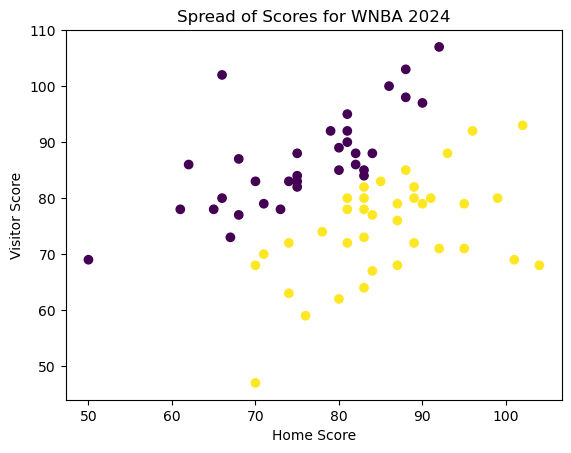

In [20]:
plt.scatter(current_schedule['HomePts'], current_schedule['AwayPts'], c=current_schedule['HomeWin']);
plt.title("Spread of Scores for WNBA 2024");
plt.xlabel("Home Score");
plt.ylabel("Visitor Score");

## Team Strengths Prediction (Normal Model) -- TODO

## Team Strengths Prediction (Thurstone-Mosteller Model) -- TODO

## Game Outcome Predictions (Bradley-Terry Model) -- TODO